# Image Processing SoSe 2024 - Assignment - 09

### Deadline is 27.06.2024 at 12:00 p.m.

#### Students: Minh Tuan Nguyen, Vinzent Hannes Jörß

Please solve the assignments together with a partner.

Make sure the code runs without errors, when clicking `Kernel` -> `Restart Kernel & Run All Cells`. Then save the notebook and upload your submission.

In [1]:
# display the plots inside the notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
from skimage.data import chelsea
import zipfile
pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

# JPEG

The Wikipedia page about [JPEG-Komprimierung](https://de.wikipedia.org/wiki/JPEG#Die_JPEG-Komprimierung) gives a good overview. Wikipedia assumes that the image data is in uint8 format for quantization. That is why we do not convert it to float in this assignment.

In [3]:
# Let's start with the input image
img = chelsea()

block_size = 8
# add some padding so the image can be evenly sliced into blocks
pad_x = 0 if img.shape[0] % (block_size * 2) == 0 else (img.shape[0] // (block_size * 2) + 1) * (block_size * 2) - img.shape[0]
pad_y = 0 if img.shape[1] % (block_size * 2) == 0 else (img.shape[1] // (block_size * 2) + 1) * (block_size * 2) - img.shape[1]
img = np.pad(img, ((0, pad_x), (0, pad_y), (0, 0)))

(38, 58, 8, 8)


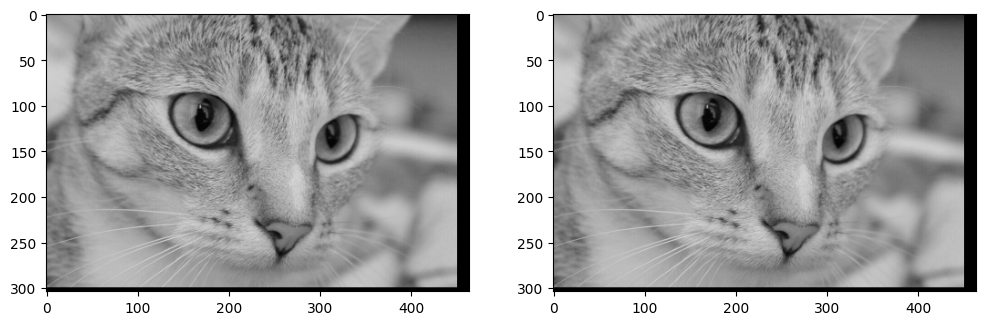

In [4]:
class Blocks:
    """Transforms an image to blocks. A (512, 512) image will become an (64, 64, 8, 8) numpy array"""
    def __init__(self, block_size=8):
        self.block_size = block_size
        
    def __call__(self, img):
        b = self.block_size
        height, width = img.shape
        assert img.shape[0] % b == 0 and img.shape[1] % b == 0
        return img.reshape(height // b, b, width // b, b).swapaxes(1, 2)

    def invert(self, blocks):
        bh, bw = blocks.shape[:2]
        b = self.block_size
        height, width = (bh*b, bw*b)
        return blocks.swapaxes(1, 2).reshape(height, width)

# test block operation on R-Channel
img_blocks = Blocks(block_size=8)(img[:, :, 0])
print(img_blocks.shape)
assert img_blocks.shape[2:] == (8, 8)
img_inv = Blocks(block_size=8).invert(img_blocks)

# the two images should be the same again after inverting
assert np.all(img[:, :, 0] == img_inv)

plt.subplot(121)
plt.imshow(img[:, :, 0], cmap='gray', vmin=0, vmax=255)
plt.subplot(122)
plt.imshow(img_inv, cmap='gray', vmin=0, vmax=255)
plt.show()

# Exercise 1 - Chroma Subsampling - 2 Points
Apply chroma subsampling to the image.

In [5]:
class ChromaSubsampling:
    """See https://en.wikipedia.org/wiki/YCbCr."""
    ycbcr = np.array([
        [0.299,  0.587,  0.114],
        [-0.168736, -0.331264,  0.5],
        [0.5, -0.418688, -0.081312],
    ])

    ycbcr_inv = np.array([
        [1.0, 0.0, 1.402],
        [1.0, -0.344136, -0.714136],
        [1.0, 1.772, 0.0],
    ])

    def __call__(self, rgb_img):
        """Transforms the rgb image to YCbCr. The cb and cr channels have half the resolution of the Y-channel.
           You can simply use the mean of four neighbours.
        """
        shape = rgb_img.shape

        ycbcr_img = np.dot(self.ycbcr, rgb_img.reshape(-1, 3).T)
        ycbcr_img = ycbcr_img.T.reshape(shape)
        ycbcr_img[:,:, [1,2]] += 128
        # subsample the cb and cr channel, so that they have half the resolution of the Y-channel.
        # A simple thing might be to use the mean of 4 neighbours.

        y = ycbcr_img[..., 0]
        cb = ycbcr_img[..., 1]
        cr = ycbcr_img[..., 2]

        # y = Blocks(2)(y).mean(axis=(2,3))
        cb = Blocks(2)(cb).mean(axis=(2,3))
        cr = Blocks(2)(cr).mean(axis=(2,3))
        return y, cb, cr

    def invert(self, inputs):
        y, cb, cr = inputs
        # y = np.repeat(y, 2, axis=0).repeat(2, axis=1)
        cb = np.repeat(cb, 2, axis=0).repeat(2, axis=1)
        cr = np.repeat(cr, 2, axis=0).repeat(2, axis=1)

        ycbcr_img = np.stack([y, cb, cr], axis=-1)
        ycbcr_img[..., [1,2]] -= 128

        rgb_img = self.ycbcr_inv @ ycbcr_img.reshape(-1, 3).T
        rgb_img = rgb_img.T.reshape(ycbcr_img.shape)
        rgb_img = np.clip(rgb_img, 0, 255)
        return rgb_img.astype(np.uint8)

Test the subsampling: The cr and cb channel should be half the resolution of the y channel.

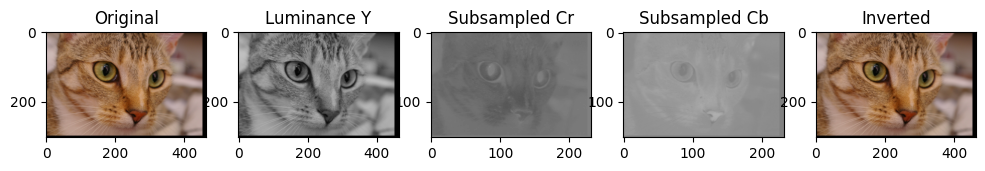

In [6]:
y, cb, cr = ChromaSubsampling()(img)
plt.subplot(151)
plt.title('Original')
plt.imshow(img, vmin=0, vmax=255)
plt.subplot(152)
plt.title('Luminance Y')
plt.imshow(y, cmap='gray', vmin=0, vmax=255)
plt.subplot(153)
plt.title('Subsampled Cr')
plt.imshow(cb, cmap='gray', vmin=0, vmax=255)
plt.subplot(154)
plt.title('Subsampled Cb')
plt.imshow(cr, cmap='gray', vmin=0, vmax=255)
plt.subplot(155)
plt.title('Inverted')
plt.imshow(ChromaSubsampling().invert((y,cb,cr)), vmin=0, vmax=255)
plt.show()

# Exercise 2 - DCT on 8x8 blocks - 2 Points
Apply DCT on 8x8 blocks. You may use `scipy.fftpack.dct`.

In [7]:
from scipy.fftpack import dct, idct

class DCTofBlocks:
    def __call__(self, blocks):
        """Returns the DCT of the blocks. The position (i, j) is a 2-dim numpy array with the dct coefficients."""
        return dct(dct(blocks, norm='ortho'), norm='ortho', axis=-2)

    def invert(self, blocks):
        """Computes the inverse DCT."""
        return idct(idct(blocks, norm='ortho'), norm='ortho', axis=-2)

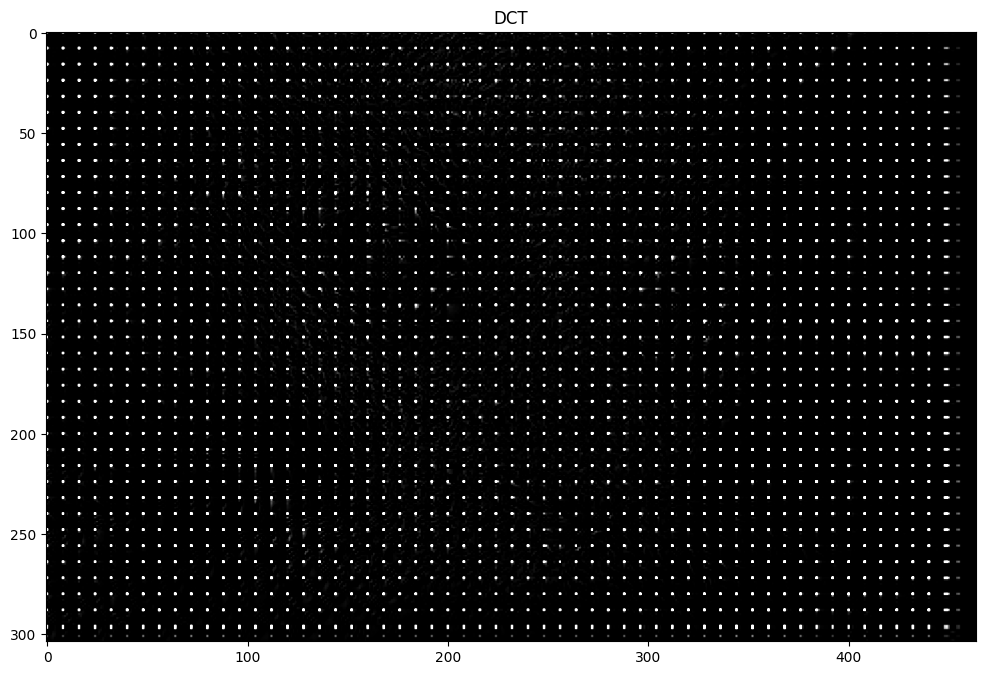

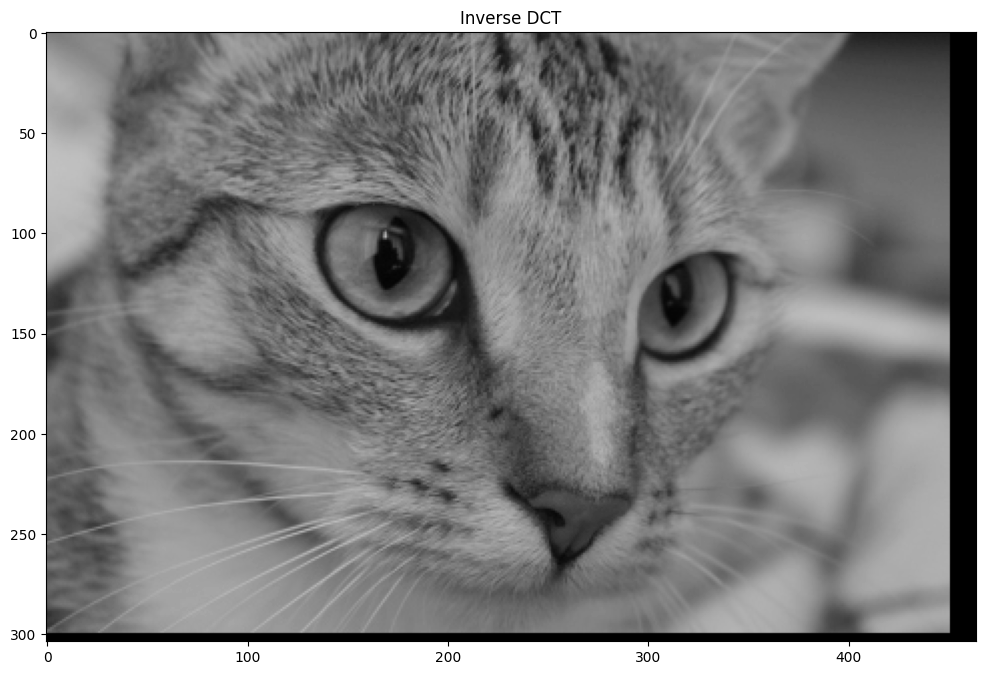

In [8]:
# print some blocks and their DCT on the y channel
y_block = Blocks()(y)
y_block_dct = DCTofBlocks()(y_block)

# show full image
dct_img = Blocks().invert(y_block_dct)
plt.imshow(dct_img, cmap='gray', vmin=0, vmax=255)
plt.title('DCT')
plt.show()

# apply inverse DCT
plt.imshow(Blocks().invert(DCTofBlocks().invert(y_block_dct)), cmap='gray', vmin=0, vmax=255)
plt.title('Inverse DCT')
plt.show()

# Exercise 3 - Quantization - 2 Points
Apply quantization on the image with a threshold.

In [9]:
class Quantization:
    def __init__(self, threshold=1):
        # you can use the Q matrix from Wikipedia
        # assuming 8x8 blocks
        self.q_matrix = np.array([
            [16, 11, 10, 16, 24,  40,  51,  61],
            [12, 12, 14, 19, 26,  58,  60,  55],
            [14, 13, 16, 24, 40,  57,  69,  56],
            [14, 17, 22, 29, 51,  87,  80,  62],
            [18, 22, 37, 56, 68,  109, 103, 77],
            [24, 35, 55, 64, 81,  104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99],
        ], dtype=float)
        self.threshold = threshold

    def __call__(self, blocks):
        """Divides the blocks by the `q_matrix` elementwise. Coefficients below the `threshold` will be set to zero."""
        blocks = blocks / self.q_matrix
        blocks[np.abs(blocks) < self.threshold] = 0
        blocks = np.rint(blocks)
        iinfo = np.iinfo(np.int8)
        blocks = np.clip(blocks, iinfo.min, iinfo.max)
        return blocks.astype(np.uint8)  # convert to unsigned int for compression stage
    
    def invert(self, blocks):
        """ For inverting multiply your elements piecewise with the Q-Matrix"""
        blocks = blocks.astype(np.int8)  # convert back from uint with 2th-complement
        blocks = blocks * self.q_matrix
        return blocks

Try different quantizations. You should see that with increasing threshold the image becomes more blurry compared to the original.

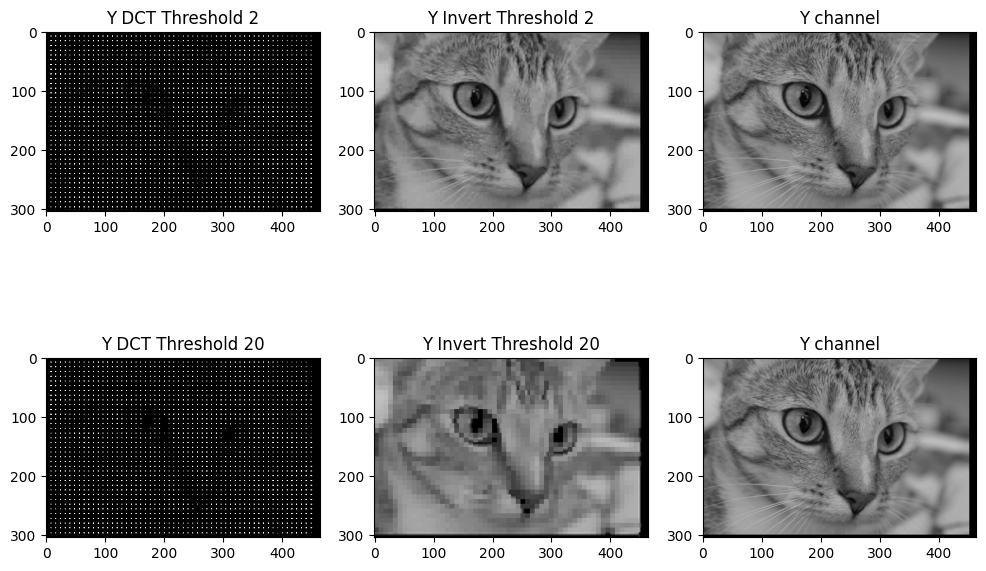

In [10]:
quant_1 = Quantization(threshold=2)(y_block_dct)
quant_img_1 = Blocks().invert(Quantization().invert(quant_1))
quant_2 = Quantization(threshold=20)(y_block_dct)
quant_img_2 = Blocks().invert(Quantization().invert(quant_2))
plt.subplot(331)
plt.imshow(quant_img_1, cmap='gray', vmin=0, vmax=255)
plt.title('Y DCT Threshold 2')
plt.subplot(332)
plt.imshow(Blocks().invert(DCTofBlocks().invert(Quantization().invert(quant_1))), cmap='gray', vmin=0, vmax=255)
plt.title('Y Invert Threshold 2')
plt.subplot(333)
plt.title('Y channel')
plt.imshow(y, cmap='gray', vmin=0, vmax=255)
plt.subplot(334)
plt.imshow(quant_img_2, cmap='gray', vmin=0, vmax=255)
plt.title('Y DCT Threshold 20')
plt.subplot(335)
plt.imshow(Blocks().invert(DCTofBlocks().invert(Quantization().invert(quant_2))), cmap='gray', vmin=0, vmax=255)
plt.title('Y Invert Threshold 20')
plt.subplot(336)
plt.imshow(y, cmap='gray', vmin=0, vmax=255)
plt.title('Y channel')
plt.show()

# Exercise 4 - Pick n-th highest (highest amplitudes of frequencies) - 2 Points
Implement the pick n-th highest algorithm

In [11]:
class PickNthHighest:
    def __init__(self, n=1):
        self.n = n

    def __call__(self, blocks):
        """Pick the nth-highest frequencies"""
        shape = blocks.shape
        blocks = np.copy(blocks).reshape(*shape[:2], -1)
        low = np.argpartition(np.abs(blocks), -self.n)[..., :-self.n]
        np.put_along_axis(blocks, low, 0, axis=-1)
        blocks = blocks.reshape(shape)
        # blocks = np.rint(blocks)
        iinfo = np.iinfo(np.int16)
        blocks = np.clip(blocks, iinfo.min, iinfo.max)
        return blocks.astype(np.uint16)  # convert to uint for compression stage
                                         # 16 bit for larger range than Quantization

    def invert(self, blocks):
        """There is no way to invert this operation. Just return the inputs."""
        blocks = blocks.astype(np.int16)  # convert back from uint to signed
        return blocks

Try out pick n-th highest compression.

In [12]:
pick_1 = PickNthHighest(n=16)(y_block_dct)
pick_img_1 = Blocks().invert(PickNthHighest().invert(pick_1))
pick_2 = PickNthHighest(n=8)(y_block_dct)
pick_img_2 = Blocks().invert(PickNthHighest().invert(pick_2))
plt.subplot(331)
plt.imshow(pick_img_1, cmap='gray', vmin = 0, vmax=255)
plt.subplot(332)
plt.imshow(Blocks().invert(DCTofBlocks().invert(PickNthHighest().invert(pick_1))), cmap='gray', vmin = 0, vmax=255)
plt.subplot(333)
plt.imshow(y, cmap='gray', vmin = 0, vmax=255)
plt.subplot(334)
plt.imshow(pick_img_2, cmap='gray', vmin = 0, vmax=255)
plt.subplot(335)
plt.imshow(Blocks().invert(DCTofBlocks().invert(PickNthHighest().invert(pick_2))), cmap='gray', vmin = 0, vmax=255)
plt.subplot(336)
plt.imshow(y, cmap='gray', vmin = 0, vmax=255)
plt.show()

# Entropy encoding
This class applies the zigzag algorithm to compress the matrix

In [13]:
class ZigZag:
    def __init__(self, n):
        self.n = n
        """Adapted from here: https://rosettacode.org/wiki/Zig-zag_matrix#Python"""
        def key(pair):
            x, y = pair
            return x+y, -y if (x+y) % 2 else y

        n = 8
        indexorder = sorted(((x,y) for x in range(n) for y in range(n)), key=key)
        # self.xs = np.zeros((self.n**2,), dtype=int)
        # self.ys = np.zeros((self.n**2,), dtype=int)
        self.back = np.zeros((n, n), dtype=int)
        # for i, (x, y) in enumerate(indexorder):
        #     self.xs[i] = x
        #     self.ys[i] = y
        #     self.back[x, y] = i
        self.xs, self.ys = np.array(indexorder).T
        self.back[self.xs, self.ys] = np.arange(n**2)
            
    def __call__(self, blocks):
        # bh, bw, h, w = blocks.shape
        # zigzack_blocks = np.zeros((bh, bw, h*w), dtype=blocks.dtype)
        # for i, block_row in enumerate(blocks):
        #     for j, block in enumerate(block_row):
        #         zigzack_blocks[i, j] = block[self.xs, self.ys]
        zigzack_blocks = blocks[..., self.xs, self.ys].copy()
        return zigzack_blocks
    
    def invert(self, zigzack_blocks):
        # bh, bw, hw = zigzack_blocks.shape
        # h = int(np.sqrt(hw))
        # blocks = np.zeros((bh, bw, h, h), dtype=zigzack_blocks.dtype)
        # for i, zigzack_row in enumerate(zigzack_blocks):
        #     for j, zigzack in enumerate(zigzack_row):
        #         blocks[i, j] = zigzack[self.back]
        blocks = zigzack_blocks[..., self.back].copy()
        return blocks

zigzag = ZigZag(8)
range_mat = np.arange(64).reshape((1, 1, 8, 8))
zigzack_mat = zigzag(range_mat)
# assert np.all(zigzag.invert(zigzack_mat) == range_mat)
assert np.array_equal(zigzag.invert(zigzack_mat), range_mat)

print(range_mat)
print(zigzack_mat)

[[[[ 0  1  2  3  4  5  6  7]
   [ 8  9 10 11 12 13 14 15]
   [16 17 18 19 20 21 22 23]
   [24 25 26 27 28 29 30 31]
   [32 33 34 35 36 37 38 39]
   [40 41 42 43 44 45 46 47]
   [48 49 50 51 52 53 54 55]
   [56 57 58 59 60 61 62 63]]]]
[[[ 0  1  8 16  9  2  3 10 17 24 32 25 18 11  4  5 12 19 26 33 40 48 41
   34 27 20 13  6  7 14 21 28 35 42 49 56 57 50 43 36 29 22 15 23 30 37
   44 51 58 59 52 45 38 31 39 46 53 60 61 54 47 55 62 63]]]


In [14]:
class Compress:
    """This class compresses arbitrary input using the bz2 algorithm"""
    def __init__(self, dtype=np.uint8):
        self.dtype = dtype
        self.max_value = (np.iinfo(dtype).max / 1.1)
        
    def __call__(self, arr):
        # print("dtype: {}".format(arr.dtype))
        # print("max: {}, min: {}".format(arr.max(), arr.min()))
        scale = max(abs(arr.max()), abs(arr.min()))
        arr = arr / scale
        arr = arr * self.max_value
        arr = np.rint(arr)
        arr = arr.astype(self.dtype)
        bytearr = arr.data.tobytes()

        return zipfile.bz2.compress(bytearr), arr.shape, arr.dtype, scale
    
    def invert(self, inputs):
        bytearr, shape, dtype, scale = inputs
        decom_bytes = zipfile.bz2.decompress(bytearr)
        arr = np.frombuffer(decom_bytes, dtype=self.dtype)
        arr = arr.astype(dtype)
        arr = arr / self.max_value * scale
        return arr.reshape(shape)

range_mat = np.arange(64, dtype=np.float64).reshape((1, 1, 8, 8))
compress = Compress()
compressed = compress(range_mat)
# print((compress.invert(compressed)))
assert np.allclose(compress.invert(compressed), range_mat, 0.5, 0.5)

In [15]:
class Jpeg:
    def __init__(self, stages):
        self.stages = stages

    def __call__(self, img):
        y, cb, cr = ChromaSubsampling()(img)
        outputs = []
        for input_ in [y, cb, cr]:
            output = input_
            for stage in self.stages:
                input_ = output
                try:
                    output = stage(input_)
                except:
                    print("Error in Stage: {}".format(type(stage).__name__))
                    raise
            outputs.append(output)
        return outputs

    def invert(self, inputs):
        outputs = []
        for output in inputs:
            for stage in self.stages[::-1]:
                input_ = output
                try:
                    output = stage.invert(input_)
                except:
                    print("Error in Stage: {}".format(type(stage).__name__))
                    raise
            outputs.append(output)
        y, cb, cr = outputs
        return ChromaSubsampling().invert([y, cb, cr])


In [16]:
def total_size_jpeg(jpeg_output):
    """Sums the number of bytes over the different compression channels: y, cb, cr"""
    nb_bytes = sum([len(x[0]) for x in jpeg_output])
    return "{:.1f}KB".format(nb_bytes / 1000)

def total_size_numpy(arr):
    return "{:.1f}KB".format(len(arr.data.tobytes()) / 1000)

def naive_compression_size(arr):
    bytearr = arr.data.tobytes()
    nb_bytes = len(zipfile.bz2.compress(bytearr))
    return "{:.1f}KB".format(nb_bytes / 1000)

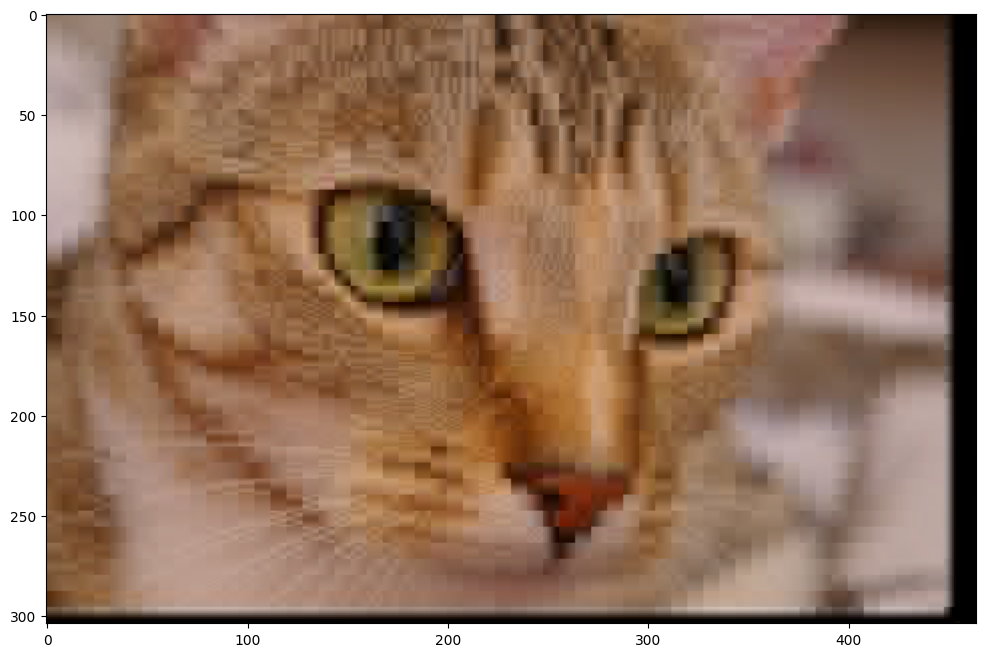

In [17]:
# build the jpeg pipeline
# for testing you can use only the first ones.
# maybe you have to adjust the Quantization threshold settings.
# jpeg = Jpeg([Blocks(8), DCTofBlocks(), Quantization(threshold=10), ZigZag(8), Compress(np.uint8)])
jpeg = Jpeg([Blocks(8), DCTofBlocks(), PickNthHighest(n=2), ZigZag(8), Compress(np.uint16)])

img_jpeg = jpeg(img)
img_reconstruct = jpeg.invert(img_jpeg)
assert img_reconstruct.shape == img.shape
# once you implemented ChromaSubsampling.invert this should have colors
plt.imshow(img_reconstruct)
plt.show()

In [18]:
np.mean((img - img_reconstruct)**2)**0.5

6.552295237461193

In [19]:
chromasubsampling_compression = Jpeg([Blocks(8), Compress()])
print("No compression: " + total_size_numpy(img))
print("Direct compression of the image: " + naive_compression_size(img))
print("Croma subsampling and compression: " + total_size_jpeg(chromasubsampling_compression(img)))
print("All compression stages: " + total_size_jpeg(img_jpeg))

No compression: 423.2KB
Direct compression of the image: 250.5KB
Croma subsampling and compression: 130.8KB
All compression stages: 12.2KB


# Exercise 5 - Pipeline comparison - 2 Points
Compare different pipeline setups and complete the tasks below.

In [20]:
# Compare the size of the images if the zigzag encoding is removed.
# Does the size change if the quantization threshold increases?

def jpeg_by(threshold, zigzag=True):
    jpeg = Jpeg([Blocks(8), DCTofBlocks(), Quantization(threshold)]
                + ([ZigZag(8)] if zigzag else [])
                + [Compress(np.uint8)])
    img_jpeg = jpeg(img)
    return total_size_jpeg(img_jpeg)

print('''\
               w/o zigzig    w/ zigzag''')

for t in [0, 1, 2, 4, 8, 16, 32, 40, 50, 60]:
    print(f"Threshold {t:>2}: {jpeg_by(t, False):>10}   {jpeg_by(t, True):>10}")

               w/o zigzig    w/ zigzag
Threshold  0:     18.0KB       17.4KB
Threshold  1:     13.2KB       13.1KB
Threshold  2:      8.5KB        8.5KB
Threshold  4:      5.1KB        5.2KB
Threshold  8:      3.4KB        3.4KB
Threshold 16:      2.7KB        2.7KB
Threshold 32:      2.4KB        2.4KB
Threshold 40:      2.3KB        2.3KB
Threshold 50:      2.0KB        2.0KB
Threshold 60:      1.5KB        1.5KB


In [21]:
# Compare the image quality of the `Quantization` vs. the `PickNthHighest` compressions. Therefore use a metric, the root
# mean square of pixel differences. Make sure that the outputs are roughly the same size. Why is one better than the other one?

def metric(arr1, arr2):
    return np.mean((arr1 - arr2)**2)**0.5

print('''\
Quantization    PickNthHighest
  Size  Diff       Size   Diff''')

for t, n in [(0, 3), (1, 2), (3, 1)]:
    quant = Jpeg([Blocks(8), DCTofBlocks(), Quantization(t), ZigZag(8), Compress(np.uint8)])
    img_quant = quant(img)
    img_quant_size = total_size_jpeg(img_quant)
    img_quant_diff = metric(quant.invert(img_quant), img)
    high = Jpeg([Blocks(8), DCTofBlocks(), PickNthHighest(n), ZigZag(8), Compress(np.uint16)])
    img_high = high(img)
    img_high_size = total_size_jpeg(img_high)
    img_high_diff = metric(high.invert(img_high), img)
    print(f"{img_quant_size:>6}{img_quant_diff:>6.3}     {img_high_size:>6} {img_high_diff:>6.3}")

Quantization    PickNthHighest
  Size  Diff       Size   Diff
17.4KB  5.43     18.9KB   5.94
13.1KB  5.78     12.2KB   6.55
 6.4KB  6.76      6.6KB   7.71


For roughly the same size, the `Quantization` compression can achieve better reconstruction, and it can keep going, since the `PickNthHighest` compression method hit rock bottom of $n = 1$. This is mainly due to larger value range which requires the use of 16 bit integer types.